##CEM

Contrastive Explanation Method, abbreviated as CEM, is a XAI Method which can give local explanations for a black box model. This method is applicable for classification datasets. CEM gives two kinds of explanations: 

Pertinent Positives (PP): For a PP, the method finds the features that should be minimally and sufficiently present (e.g. important pixels in an image) to predict the same class as on the original instance.  PP works similarly to Anchors.


Pertinent Negatives (PN): PN’s on the other hand identify what features should be minimally and necessarily absent from the instance to be explained in order to maintain the original prediction class. The aim of PN’s is not to provide a full set of characteristics that should be absent in the explained instance, but to identify a minimal set of features that is enough to differentiate it from the nearest different class. PN works similarly to Counterfactuals.






In [ ]:
!pip install alibi

     |████████████████████████████████| 225kB 2.5MB/s 
     |████████████████████████████████| 327kB 7.9MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 204kB 10.7MB/s 
     |████████████████████████████████| 28.0MB 141kB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456462 sha256=75f62bf895addf6215f3c06a4174c243932d69e6988a59f6482f6d0f8c341105
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052144 sha256=6172085675882e7d29fe1ce47e7a697b9e982fb5336e44683e55e041c3ac194f
  Stored in directory: /root/.cache/pip/wheels/2a/2b/0a/d6fb6235c56d014d224bca760d15d7cbdd820813085ffcd35d
Successfully built shap spacy-lookups-data


In [ ]:
import numpy as np
import os
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior()
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, Reshape, MaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import IntegratedGradients
import matplotlib.pyplot as plt
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # True
from alibi.explainers import CEM

TF version:  2.3.0
Eager execution enabled:  False


In [ ]:
train, test = tf.keras.datasets.fashion_mnist.load_data()
X_train, y_train = train
X_test, y_test = test
test_labels = y_test.copy()
train_labels = y_train.copy()

X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


Training the model:

In [ ]:
load_fashion_mnist_model = False
save_model = True

In [ ]:
filepath = './model_mnist/'  # change to directory where model is saved
if load_fashion_mnist_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]), dtype=tf.float32)
    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)

    x = Conv2D(32, 2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(10, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # train model
    model.fit(X_train,
              y_train,
              epochs=6,
              batch_size=256,
              verbose=1,
              validation_data=(X_test, y_test)
              )
    if save_model:
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        model.save(os.path.join(filepath, 'model.h5'))

Epoch 1/6
235/235 [==============================] - 63s 266ms/step - loss: 0.7231 - accuracy: 0.7342 - val_loss: 0.4494 - val_accuracy: 0.8355
Epoch 2/6
235/235 [==============================] - 62s 263ms/step - loss: 0.4583 - accuracy: 0.8337 - val_loss: 0.3783 - val_accuracy: 0.8648
Epoch 3/6
235/235 [==============================] - 62s 262ms/step - loss: 0.4050 - accuracy: 0.8531 - val_loss: 0.3461 - val_accuracy: 0.8749
Epoch 4/6
235/235 [==============================] - 62s 262ms/step - loss: 0.3766 - accuracy: 0.8630 - val_loss: 0.3262 - val_accuracy: 0.8798
Epoch 5/6
235/235 [==============================] - 62s 263ms/step - loss: 0.3524 - accuracy: 0.8725 - val_loss: 0.3061 - val_accuracy: 0.8874
Epoch 6/6
235/235 [==============================] - 62s 264ms/step - loss: 0.3395 - accuracy: 0.8758 - val_loss: 0.2940 - val_accuracy: 0.8916


In [ ]:
model = load_model('./model_mnist/model.h5')
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.8916000127792358


Generating contrastive explaination for pertinent negative:

Consider the twelfth instance of testing data.

In [ ]:
idx = 11
X = X_test[idx].reshape((1,) + X_test[idx].shape)
print('Prediction on instance to be explained: {}'.format([np.argmax(model.predict(X))]))
print('Prediction probabilities for each class on the instance: {}'.format(model.predict(X)))

Prediction on instance to be explained: [5]
Prediction probabilities for each class on the instance: [[2.1488286e-04 3.4324466e-06 1.1117347e-04 2.2271364e-05 3.0728035e-05
  9.8052913e-01 5.9215607e-05 1.8225752e-02 2.7964843e-04 5.2389823e-04]]


The original prediction class is 5 that represtns sandal, since it has a greater prediction probability.

Here, 

*   mode : 'PN' (Pertinent Negative) or 'PP' (Pertinent Positive)
*   shape : Shape of the current instance. As CEM is applicable for single explanations, we take 1.
*   kappa, beta, gamma, c_init, c_steps are all mathematical terms for calculating loss
*   max_iterations : the total no. of loss optimization steps for each value of c
*   feature_range : global or feature wise minimum and maximum values for the changed instance
*   clip : minimum and maximum gradient values
*   lr_init : initial learning rate 



In [ ]:
mode = 'PN' 
shape = (1,) + X_train.shape[1:]  
kappa = .2 
            
            
beta = .1  
c_init = 10. 
c_steps = 10
max_iterations = 1000  
feature_range = (X_train.min(axis=0).reshape(shape)-.1,  
                 X_train.max(axis=0).reshape(shape)+.1)  
clip = (-1000.,1000.)  
lr_init = 1e-2  

In [ ]:
lr = load_model('./model_mnist/model.h5')

# initialize CEM explainer and explain instance
cem = CEM(lr, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          max_iterations=max_iterations, c_init=c_init, c_steps=c_steps,
          learning_rate_init=lr_init, clip=clip)
cem.fit(X_train, no_info_type='median')  
explanation = cem.explain(X, verbose=False)

Predicted class: [5]


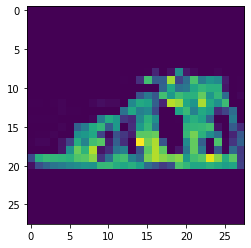

In [ ]:
print('Predicted class: {}'.format([explanation.X_pred]))
plt.imshow(explanation.X.reshape(28, 28));

Pertinent negative prediction: 8


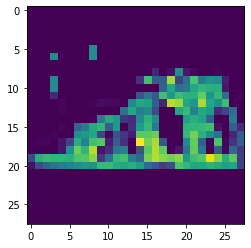

In [ ]:
print('Pertinent negative prediction: {}'.format(explanation.PN_pred))
plt.imshow(explanation.PN.reshape(28, 28));

The above result clearly shows that the pertinent negative method pushes the prediction to get a prediction different from the original prediction which is 5 (sandal) to 7 (sneaker) in this case.

It shows the perturbations created to the original instance in order to change the prediction from sandal to sneaker. These are the minimal changes that should be absent to prevent the result from changing.

In [ ]:
mode = 'PP'

In [ ]:
# define model
lr = load_model('./model_mnist/model.h5')

# initialize CEM explainer and explain instance
cem = CEM(lr, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          max_iterations=max_iterations, c_init=c_init, c_steps=c_steps,
          learning_rate_init=lr_init, clip=clip)
cem.fit(X_train, no_info_type='median')
explanation = cem.explain(X, verbose=False)

Predicted class: [5]


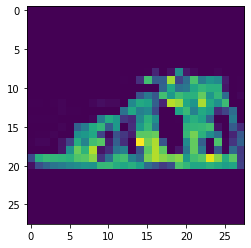

In [ ]:
print('Predicted class: {}'.format([explanation.X_pred]))
plt.imshow(explanation.X.reshape(28, 28));

Pertinent positive prediction: 5


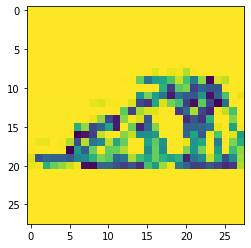

In [ ]:
print('Pertinent positive prediction: {}'.format(explanation.PP_pred))
plt.imshow(explanation.PP.reshape(28, 28));

The above result shows that the predicted class remains same on applying PP. The image generated using PP gives a faint idea of the shape which is suffusuent to give the original result which is sandal. The above pixels shown should be compulsorily and minimally present in order to get the same original class 5 as predicted class.